# 11.3 Predictive coding (Rao & Ballard, 1999) モデル
Predictive codingの初めの数理的モデルとなる ([Rao & Ballard, *Nat. Neurosci*. 1999](https://www.nature.com/articles/nn0199_79))を実装する。

## 11.3.1 観測世界の階層的予測
構築するネットワークは入力層を含め、3層のネットワークとする。網膜への入力として画像 $\boldsymbol{I} \in \mathbb{R}^{n_0}$を考える。画像 $\boldsymbol{I}$ の観測世界における隠れ変数、すなわち**潜在変数** (latent variable)を$\boldsymbol{r} \in \mathbb{R}^{n_1}$とし、ニューロン群によって発火率で表現されているとする (真の変数と $\boldsymbol{r}$は異なるので文字を分けるべきだが簡単のためにこう表す)。このとき、

$$
\boldsymbol{I} = f(U\boldsymbol{r}) + \boldsymbol{n} \tag{1}
$$

が成立しているとする。ただし、$f(\cdot)$は活性化関数 (activation function)、$U \in \mathbb{R}^{n_0 \times n_1}$は重み行列である。$\boldsymbol{n} \in \mathbb{R}^{n_0} $は平均0, 分散 $\sigma^2$ のGaussian ノイズ項とする。

潜在変数 $\boldsymbol{r}$はさらに高次 (higher-level)の潜在変数 $\boldsymbol{r}^h$により、次式で表現される。

$$
\boldsymbol{r} = \boldsymbol{r}^{td}+\boldsymbol{n}^{td}=f(U^h \boldsymbol{r}^h)+\boldsymbol{n}^{td} \tag{2}
$$

ただし、Top-downの予測信号を $\boldsymbol{r}^{td}:=f(U^h \boldsymbol{r}^h)$とした。また、$\boldsymbol{r}^{td} \in \mathbb{R}^{n_1}$, $\boldsymbol{r}^{h} \in \mathbb{R}^{n_2}$, $U^h \in \mathbb{R}^{n_1 \times n_2}$ である。 $\boldsymbol{n}^{td} \in \mathbb{R}^{n_1} $は平均0, 分散 $\sigma_{td}^2$ のGaussian ノイズ項とする。

話は飛ぶが、Predictive codingのネットワークの特徴は
- 階層的な構造
- 高次による低次の予測 (Feedback or Top-down信号)
- 低次から高次への誤差信号の伝搬 (Feedforward or Bottom-up 信号)

である。ここまでは高次表現による低次表現の予測、というFeedback信号について説明してきたが、この部分はSparse codingでも同じである。それではPredictive codingのもう一つの要となる、低次から高次への予測誤差の伝搬というFeedforward信号はどのように導かれるのだろうか。結論から言えば、これは**復元誤差 (reconstruction error)の最小化を行う再帰的ネットワーク (recurrent network)を考慮することで自然に導かれる**。

## 11.3.2 損失関数と学習則
### 損失関数の設定
前節では2層までのパラメータを最適化することを考えました、高次の活動も考慮して損失関数 $E$を次のように再定義する。

$$
\begin{align}
E=\underbrace{\frac{1}{\sigma^{2}}\|\boldsymbol{I}-f(U \boldsymbol{r})\|^2+\frac{1}{\sigma_{t d}^{2}}\left\|\boldsymbol{r}-f(U^h \boldsymbol{r}^h)\right\|^2}_{\text{reconstruction error}}+\underbrace{g(\boldsymbol{r})+g(\boldsymbol{r}^{h})+h(U)+h(U^h)}_{\text{sparsity penalty}}\tag{8}
\end{align}
$$


### 再帰ネットワークの更新則
簡単のために$\boldsymbol{x}:=U\boldsymbol{r}, \boldsymbol{x}^h:=U^h\boldsymbol{r}^h$とする。

$$
\begin{align}
\frac{d \boldsymbol{r}}{d t}&=-\frac{k_{1}}{2} \frac{\partial E}{\partial \boldsymbol{r}}=k_{1}\cdot\Bigg(\frac{1}{\sigma^{2}} U^{T}\bigg[\frac{\partial f(\boldsymbol{x})}{\partial \boldsymbol{x}}\odot\underbrace{(\boldsymbol{I}-f(\boldsymbol{x}))}_{\text{bottom-up error}}\bigg]-\frac{1}{\sigma_{t d}^{2}}\underbrace{\left(\boldsymbol{r}-f(\boldsymbol{x}^h)\right)}_{\text{top-down error}}-\frac{1}{2}g'(\boldsymbol{r})\Bigg)\tag{9}\\
\frac{d \boldsymbol{r}^h}{d t}&=-\frac{k_{1}}{2} \frac{\partial E}{\partial \boldsymbol{r}^h}=k_{1}\cdot\Bigg(\frac{1}{\sigma_{t d}^{2}}(U^h)^T\bigg[\frac{\partial f(\boldsymbol{x}^h)}{\partial \boldsymbol{x}^h}\odot\underbrace{\left(\boldsymbol{r}-f(\boldsymbol{x}^h)\right)}_{\text{bottom-up error}}\bigg]-\frac{1}{2}g'(\boldsymbol{r}^h)\Bigg)\tag{10}
\end{align}
$$

ただし、$k_1$は更新率 (updating rate)である。または、発火率の時定数を$\tau:=1/k_1$として、$k_1$は発火率の時定数$\tau$の逆数であると捉えることもできる。ここで(9)式において、中間表現 $\boldsymbol{r}$ のダイナミクスはbottom-up errorとtop-down errorで記述されている。このようにbottom-up errorが $\boldsymbol{r}$ への入力となることは自然に導出される。なお、top-down errorに関しては高次からの予測 (prediction)の項 $f(\boldsymbol{x}^h)$とleaky-integratorとしての項 $-\boldsymbol{r}$に分割することができる。また$U^T, (U^h)^T$は重み行列の転置となっており、bottom-upとtop-downの投射において対称な重み行列を用いることを意味している。$-g'(\boldsymbol{r})$は発火率を抑制してスパースにすることを目的とする項だが、無理やり解釈をすると自己再帰的な抑制と言える。

In [1]:
using PyPlot

### 画像データの読み込み
データは<http://www.rctn.org/bruno/sparsenet/>からダウンロードできる。`IMAGES_RAW.mat`は10枚の自然画像で、`IMAGES.mat`はそれを白色化したものである。`mat`ファイルの読み込みには[MAT.jl](https://github.com/JuliaIO/MAT.jl)を用いる。

In [2]:
using MAT

In [3]:
# datasets from http://www.rctn.org/bruno/sparsenet/
mat_images = matopen("_static/datasets/IMAGES.mat")
imgs = read(mat_images, "IMAGES")

close(mat_images)

### モデルの定義
必要なパッケージを読み込む。

In [4]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using LinearAlgebra
using Random
using Statistics
using ProgressMeter

モデルを定義する。

In [5]:
@kwdef struct RBParameter{FT}
    α::FT = 1.0
    αh::FT = 0.05
    var::FT = 1.0
    vartd::FT = 10
    inv_var::FT = 1/var       
    inv_vartd::FT = 1/vartd
    k1::FT = 0.3 # k_1: update rate
    λ::FT = 0.02 # regularization parameter
end

@kwdef mutable struct RaoBallard1999Model{FT}
    param::RBParameter = RBParameter{FT}()
    num_units_lv0::UInt16 = 256 # number of units of level0
    num_units_lv1::UInt16 = 32
    num_units_lv2::UInt16 = 128
    num_lv1::UInt16 = 3
    k2::FT = 0.2 # k_2: learning rate
    r::Array{FT} = zeros(num_lv1, num_units_lv1) # activity of neurons
    rh::Array{FT} = zeros(num_units_lv2) # activity of neurons
    U::Array{FT} = randn(num_units_lv0, num_units_lv1) .* sqrt(2.0 / (num_units_lv0+num_units_lv1))
    Uh::Array{FT} = randn(num_lv1*num_units_lv1, num_units_lv2) .* sqrt(2.0 / (num_lv1*num_units_lv1+num_units_lv2))
end

パラメータを更新する関数を定義する。

In [6]:
function update!(variable::RaoBallard1999Model, param::RBParameter, inputs::Array, training::Bool)
    @unpack num_units_lv0, num_units_lv1, num_units_lv2, num_lv1, k2, r, rh, U, Uh = variable
    @unpack α, αh, var, vartd, inv_var, inv_vartd, k1, λ = param

    r_reshaped = r[:] # (96)

    fx = r * U' # (3, 256)
    fxh = Uh * rh # (96, )

    # Calculate errors
    error = inputs - fx # (3, 256)
    errorh = r_reshaped - fxh # (96, ) 
    errorh_reshaped = reshape(errorh, (num_lv1, num_units_lv1)) # (3, 32)

    g_r = α * r ./ (1.0 .+ r .^ 2) # (3, 32)
    g_rh = αh * rh ./ (1.0 .+ rh .^ 2) # (64, )

    # Update r and rh
    dr = k1 * (inv_var * error * U - inv_vartd * errorh_reshaped - g_r)
    drh = k1 * (inv_vartd * Uh' * errorh - g_rh)
    
    r[:, :] += dr
    rh[:] += drh
    
    if training 
        U[:, :] += k2 * (inv_var * error' * r - num_lv1 * λ * U)
        Uh[:, :] += k2 * (inv_vartd * errorh * rh' - λ * Uh)
    end

    return error, errorh, dr, drh
end

update! (generic function with 1 method)

入力に乗じるGaussianフィルタを定義する。

In [7]:
# Gaussian mask for inputs
function GaussianMask(sizex=16, sizey=16, sigma=5)
    x = 0:sizex-1
    y = 0:sizey-1
    X = [i for i in x, j in 1:length(y)]
    Y = [j for i in 1:length(x), j in y]
    
    x0 = (sizex-1) / 2
    y0 = (sizey-1) / 2
    mask = exp.(-((X .- x0) .^2 + (Y .- y0) .^2) / (2.0*(sigma^2)))
    return mask ./ sum(mask)
end

GaussianMask (generic function with 4 methods)

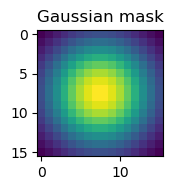

In [8]:
gau = GaussianMask()
figure(figsize=(2,2))
title("Gaussian mask")
imshow(gau)
tight_layout()

損失関数を定義する。

In [9]:
function calculate_total_error(error, errorh, variable::RaoBallard1999Model, param::RBParameter)
    @unpack num_units_lv0, num_units_lv1, num_units_lv2, num_lv1, k2, r, rh, U, Uh = variable
    @unpack α, αh, var, vartd, inv_var, inv_vartd, k1, λ = param
    recon_error = inv_var * sum(error.^2) + inv_vartd * sum(errorh.^2)
    sparsity_r = α * sum(r.^2) + αh * sum(rh.^2)
    sparsity_U = λ * (sum(U.^2) + sum(Uh.^2))
    return recon_error + sparsity_r + sparsity_U
end

calculate_total_error (generic function with 1 method)

シミュレーションを実行する関数を定義する。外側の`for loop`では画像パッチの作成と`r`の初期化を行う。内側の`for loop`では`r`が収束するまで更新を行い、収束したときに重み行列`Phi`を更新する。

In [10]:
function run_simulation(imgs, num_iter, nt_max, eps)
    # Define model
    model = RaoBallard1999Model{Float32}()
    
    # Simulation constants
    H, W, num_images = size(imgs)
    input_scale = 40 # scale factor of inputs
    gmask = GaussianMask() # Gaussian mask
    errorarr = zeros(num_iter) # Vector to save errors    
    
    # Run simulation
    @showprogress "Computing..." for iter in 1:num_iter
        # Get images randomly
        idx = rand(1:num_images)
        img = imgs[:, :, idx]

        # Get the coordinates of the upper left corner of clopping image randomly.
        beginx = rand(1:W-27)
        beginy = rand(1:H-17)
        img_clopped = img[beginy:beginy+15, beginx:beginx+25]

        # Clop three patches
        inputs = hcat([(gmask .* img_clopped[:, 1+i*5:i*5+16])[:] for i = 0:2]...)'
        inputs = (inputs .- mean(inputs)) .* input_scale

        # Reset states
        model.r = inputs * model.U 
        model.rh = model.Uh' * model.r[:]

        # Input an image patch until latent variables are converged 
        for i in 1:nt_max
            # Update r and rh without update weights 
            error, errorh, dr, drh = update!(model, model.param, inputs, false)

            # Compute norm of r and rh
            dr_norm = sqrt(sum(dr.^2))
            drh_norm = sqrt(sum(drh.^2))

            # Check convergence of r and rh, then update weights
            if dr_norm < eps && drh_norm < eps
                error, errorh, dr, drh = update!(model, model.param, inputs, true)
                errorarr[iter] = calculate_total_error(error, errorh, model, model.param) # Append errors
                break
            end

            # If failure to convergence, break and print error
            if i >= nt_max-2
                println("Error at patch:", iter)
                println(dr_norm, drh_norm)
                break
            end
        end


        # Decay learning rate         
        if iter % 40 == 39
            model.k2 /= 1.015
        end

        # Print moving average error
        if iter % 1000 == 0
            moving_average_error = mean(errorarr[iter-999:iter])
            println("iter: ", iter, "/", num_iter, ", Moving average error:", moving_average_error)
        end
    end
    return model, errorarr
end

run_simulation (generic function with 1 method)

### シミュレーションの実行

In [11]:
# Simulation constants
num_iter = 5000 # number of iterations
nt_max = 1000 # Maximum number of simulation time
eps = 1e-3 # small value which determines convergence

model, errorarr = run_simulation(imgs, num_iter, nt_max, eps)

Computing...  0%|█                                      |  ETA: 4:16:07

Computing...  0%|█                                      |  ETA: 0:12:54

Computing...  1%|█                                      |  ETA: 0:08:37

Computing...  1%|█                                      |  ETA: 0:06:26

Computing...  1%|█                                      |  ETA: 0:05:10

Computing...  2%|█                                      |  ETA: 0:04:11

Computing...  2%|█                                      |  ETA: 0:03:30

Computing...  2%|█                                      |  ETA: 0:03:04

Computing...  3%|█                                      |  ETA: 0:02:41

Computing...  3%|██                                     |  ETA: 0:02:21

Computing...  4%|██                                     |  ETA: 0:02:00

Computing...  4%|██                                     |  ETA: 0:01:43

Computing...  5%|██                                     |  ETA: 0:01:29

Computing...  6%|███                                    |  ETA: 0:01:17

Computing...  7%|███                                    |  ETA: 0:01:08

Computing...  8%|███                                    |  ETA: 0:01:01

Computing...  9%|████                                   |  ETA: 0:00:55

Computing...  9%|████                                   |  ETA: 0:00:50

Computing... 10%|█████                                  |  ETA: 0:00:46

Computing... 11%|█████                                  |  ETA: 0:00:43

Computing... 12%|█████                                  |  ETA: 0:00:40

Computing... 13%|██████                                 |  ETA: 0:00:38

Computing... 14%|██████                                 |  ETA: 0:00:36

Computing... 15%|██████                                 |  ETA: 0:00:34

Computing... 16%|███████                                |  ETA: 0:00:32

Computing... 17%|███████                                |  ETA: 0:00:31

Computing... 18%|███████                                |  ETA: 0:00:29

Computing... 19%|████████                               |  ETA: 0:00:28

Computing... 20%|████████                               |  ETA: 0:00:27

iter: 1000/5000, Moving average error:

Computing... 20%|████████                               |  ETA: 0:00:27

2.07141417007341


Computing... 21%|█████████                              |  ETA: 0:00:26

Computing... 22%|█████████                              |  ETA: 0:00:25

Computing... 23%|█████████                              |  ETA: 0:00:24

Computing... 24%|██████████                             |  ETA: 0:00:23

Computing... 25%|██████████                             |  ETA: 0:00:22

Computing... 26%|██████████                             |  ETA: 0:00:21

Computing... 27%|███████████                            |  ETA: 0:00:21

Computing... 28%|███████████                            |  ETA: 0:00:20

Computing... 29%|████████████                           |  ETA: 0:00:19

Computing... 30%|████████████                           |  ETA: 0:00:18

Computing... 31%|█████████████                          |  ETA: 0:00:18

Computing... 32%|█████████████                          |  ETA: 0:00:17

Computing... 33%|█████████████                          |  ETA: 0:00:17

Computing... 34%|██████████████                         |  ETA: 0:00:16

Computing... 35%|██████████████                         |  ETA: 0:00:16

Computing... 36%|███████████████                        |  ETA: 0:00:15

Computing... 37%|███████████████                        |  ETA: 0:00:15

Computing... 38%|███████████████                        |  ETA: 0:00:14

Computing... 39%|████████████████                       |  ETA: 0:00:14

iter: 2000/5000, Moving average error:1.6392302622149277


Computing... 40%|████████████████                       |  ETA: 0:00:13

Computing... 41%|█████████████████                      |  ETA: 0:00:13

Computing... 42%|█████████████████                      |  ETA: 0:00:13

Computing... 43%|█████████████████                      |  ETA: 0:00:12

Computing... 44%|██████████████████                     |  ETA: 0:00:12

Computing... 45%|██████████████████                     |  ETA: 0:00:12

Computing... 46%|██████████████████                     |  ETA: 0:00:11

Computing... 47%|███████████████████                    |  ETA: 0:00:11

Computing... 48%|███████████████████                    |  ETA: 0:00:11

Computing... 49%|███████████████████                    |  ETA: 0:00:11

Computing... 50%|████████████████████                   |  ETA: 0:00:10

Computing... 51%|████████████████████                   |  ETA: 0:00:10

Computing... 52%|█████████████████████                  |  ETA: 0:00:10

Computing... 52%|█████████████████████                  |  ETA: 0:00:09

Computing... 53%|█████████████████████                  |  ETA: 0:00:09

Computing... 54%|██████████████████████                 |  ETA: 0:00:09

Computing... 55%|██████████████████████                 |  ETA: 0:00:09

Computing... 56%|██████████████████████                 |  ETA: 0:00:08

Computing... 57%|███████████████████████                |  ETA: 0:00:08

Computing... 58%|███████████████████████                |  ETA: 0:00:08

Computing... 59%|████████████████████████               |  ETA: 0:00:08

iter: 3000/5000, Moving average error:1.62744758603981


Computing... 60%|████████████████████████               |  ETA: 0:00:08

Computing... 61%|████████████████████████               |  ETA: 0:00:07

Computing... 62%|█████████████████████████              |  ETA: 0:00:07

Computing... 63%|█████████████████████████              |  ETA: 0:00:07[39

Computing... 64%|██████████████████████████             |  ETA: 0:00:07

Computing... 66%|██████████████████████████             |  ETA: 0:00:06

Computing... 66%|██████████████████████████             |  ETA: 0:00:06

Computing... 68%|███████████████████████████            |  ETA: 0:00:06

Computing... 69%|███████████████████████████            |  ETA: 0:00:06

Computing... 69%|████████████████████████████           |  ETA: 0:00:05

Computing... 70%|████████████████████████████           |  ETA: 0:00:05

Computing... 71%|████████████████████████████           |  ETA: 0:00:05

Computing... 72%|█████████████████████████████          |  ETA: 0:00:05

Computing... 73%|█████████████████████████████          |  ETA: 0:00:05

Computing... 74%|█████████████████████████████          |  ETA: 0:00:05

Computing... 75%|██████████████████████████████         |  ETA: 0:00:04

Computing... 76%|██████████████████████████████         |  ETA: 0:00:04

Computing... 77%|███████████████████████████████        |  ETA: 0:00:04

Computing... 78%|███████████████████████████████        |  ETA: 0:00:04[39

Computing... 79%|███████████████████████████████        |  ETA: 0:00:04

Computing... 80%|████████████████████████████████       |  ETA: 0:00:03

iter: 4000/5000, Moving average error:1.712339423534575

Computing... 81%|████████████████████████████████       |  ETA: 0:00:03

Computing... 82%|████████████████████████████████       |  ETA: 0:00:03

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:03

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:03

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:03

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:02

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:02

Computing... 87%|███████████████████████████████████    |  ETA: 0:00:02

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:02

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:02

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:02

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:02

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:01

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:01

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:01

Computing... 95%|█████████████████████████████████████  |  ETA: 0:00:01

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:01

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:01

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:00

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:00

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:00

iter: 5000/5000, Moving average error:1.728442310244673


Computing...100%|███████████████████████████████████████| Time: 0:00:16[39

m


(RaoBallard1999Model{Float32}(RBParameter{Float32}(1.0f0, 0.05f0, 1.0f0, 10.0f0, 1.0f0, 0.1f0, 0.3f0, 0.02f0), 0x0100, 0x0020, 0x0080, 0x0003, 0.03110101f0, Float32[0.0011936711 -0.0016657583 … -0.0015449642 -0.00012640835; 0.0017843439 -0.0008415675 … -0.0014921357 -0.0024346465; 0.0027756244 -0.018304713 … -0.010511845 0.0030228684], Float32[3.616689f-7, -5.403301f-8, 1.3681192f-6, -1.1336673f-7, -3.6163408f-7, -6.707493f-7, -1.3319128f-6, -4.3613616f-7, -7.2842376f-8, 9.177179f-7  …  3.5108468f-7, -6.0323475f-7, 7.017647f-7, -4.8591824f-7, -4.0851293f-7, -8.0752756f-7, 3.644135f-7, 3.299376f-8, 4.7550685f-7, -3.8443822f-8], Float32[-0.00022180688 0.0011647275 … 0.0006912917 -0.0001372362; -0.00023667257 0.0006634277 … 0.00046115773 5.2172305f-5; … ; -0.00029313436 0.0011582935 … 0.000745914 -0.00012018335; -0.00030993644 0.0013139945 … 0.0008285371 -0.0001878168], Float32[8.033493f-6 -5.7219972f-6 … 8.138389f-6 1.2401184f-5; -1.3114341f-5 1.318761f-6 … -1.1547241f-5 2.6323349f-5; … 

### 訓練中の損失の描画
訓練中の損失の変化を描画してみよう。損失が低下し、学習が進行したことが分かる。

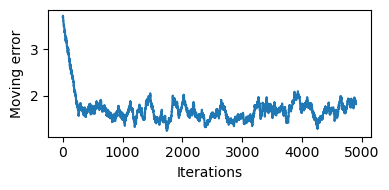

In [12]:
function moving_average(x, n=100)
    ret = cumsum(x)
    ret[n:end] = ret[n:end] - ret[1:end-n+1]
    return ret[n - 1:end] / n
end

# Plot error
moving_average_error = moving_average(errorarr)
figure(figsize=(4, 2))
ylabel("Moving error")
xlabel("Iterations")
plot(1:size(moving_average_error)[1], moving_average_error)
tight_layout()

### 重み行列 (受容野)の描画
学習後の重み行列 `Phi` ($\Phi$)を可視化してみよう。

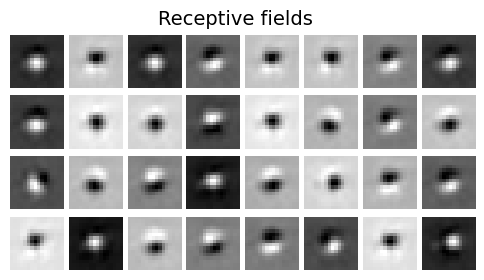

In [13]:
# Plot Receptive fields
figure(figsize=(6, 3))
subplots_adjust(hspace=0.1, wspace=0.1)
for i in 1:32
    subplot(4, 8, i)
    imshow(reshape(model.U[:, i], (16, 16)), cmap="gray")
    axis("off")
end
suptitle("Receptive fields", fontsize=14)
subplots_adjust(top=0.9)

白色が**ON領域**(興奮)、黒色が**OFF領域**(抑制)を表す。Gaborフィルタ様の局所受容野が得られており、これは一次視覚野(V1)における単純型細胞(simple cells)の受容野に類似している。

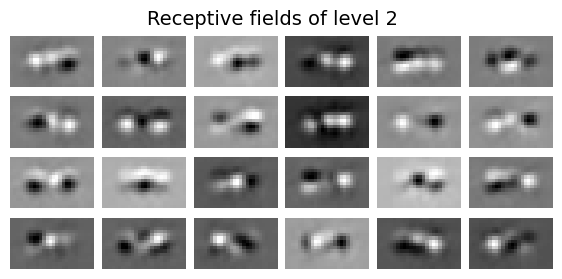

In [14]:
# Plot Receptive fields of level 2
zero_padding = zeros(80, 32)
U0 = [model.U; zero_padding; zero_padding]
U1 = [zero_padding; model.U; zero_padding]
U2 = [zero_padding; zero_padding; model.U]
U_ = [U0 U1 U2]
Uh_ = U_ * model.Uh 

figure(figsize=(7, 3))
subplots_adjust(hspace=0.1, wspace=0.1)
for i in 1:24
    subplot(4, 6, i)
    imshow(reshape(Uh_[:, i], (16, 26)), cmap="gray")
    axis("off")
end

suptitle("Receptive fields of level 2", fontsize=14)
subplots_adjust(top=0.9)